In [1]:
# NOTE FOR LOCAL EXECUTION: use pytorch kernel and execute the code below to specify cuda device
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# BERT and Explainable AI

## Load required libraries

In [2]:
!pip install pandas
!pip install transformers
!pip install transformers-interpret

## Import libraries

In [1]:
from utils import *
import pandas as pd
import pickle
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import SequenceClassificationExplainer

c:\Users\david\OneDrive - Universitat de Barcelona\GitHub\New explainability implementation\mbti\masked\FT\utils.py:10: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  auc_metric = load_metric("roc_auc", trust_remote_code=True)


## Load data

In [2]:
# Original data
#df = pd.read_csv(r"C:\Users\david\OneDrive - Universitat de Barcelona (1)\Documentos\GitHub\Explainability\essays.csv", encoding = "latin-1")

# Alternatively, load fragmented validation and test partitions
df_train = pd.read_csv(r"C:\Users\david\OneDrive - Universitat de Barcelona\GitHub\New explainability implementation\datasets\df_mbti_fragm_train.csv")
df_valid = pd.read_csv(r"C:\Users\david\OneDrive - Universitat de Barcelona\GitHub\New explainability implementation\datasets\df_mbti_fragm_valid.csv")
df_test = pd.read_csv(r"C:\Users\david\OneDrive - Universitat de Barcelona\GitHub\New explainability implementation\datasets\df_mbti_fragm_test.csv")
#df = pd.concat([df_valid, df_test], axis=0, ignore_index=True)
df = df_test

df.head()

,type,text,I/E,N/S,F/T,J/P,masked_text_bert,num_replacements,masked_text_roberta,random_masked_text_bert,random_masked_text_roberta
0,INFP,"they sleep, but yeah. How long do you think yo...",1,1,1,0,"they sleep, but yeah. How long do you think yo...",0,"they sleep, but yeah. How long do you think yo...","they sleep, but yeah. How long do you think yo...","they sleep, but yeah. How long do you think yo..."
1,INFJ,conflict earlier today in school. I stood up f...,1,1,1,1,conflict earlier today in school. I stood up f...,0,conflict earlier today in school. I stood up f...,conflict earlier today in school. I stood [UNK...,conflict earlier today in school. I stood up f...
2,INTJ,is the interesting one. Assume that everyone i...,1,1,0,1,is the interesting one. Assume that everyone i...,0,is the interesting one. Assume that everyone i...,is the interesting one. Assume that everyone i...,is the interesting one. Assume that everyone i...
3,INFJ,experience and now I'm forever traumatized.|||...,1,1,1,1,experience and now I'm forever traumatized.|||...,1,experience and now I'm forever traumatized.|||...,experience and now I'm forever traumatized.|||...,experience and now I'm forever traumatized.|||...
4,ENTP,I can respect that. I'd take an INFP any day o...,0,1,0,0,I can respect that. I'd take an [UNK] any day ...,8,I can respect that. I'd take an <unk> any day ...,I can respect that. I'd take an INFP any day o...,I can respect that. I'd take an INFP <unk> day...


In [5]:
print(len(df))

4416


## Notebook Settings

In [3]:
trait = "F/T"
text_colname="masked_text_bert"

## Load the fine-tuned model

In [4]:
# Path to the fine-tuned model
#model_path = r"C:\Users\david\OneDrive - Universitat de Barcelona (1)\Documentos\GitHub\Explainability\Agreeableness\results_agreeableness"  # my laptop
model_path = r"C:\Users\david\OneDrive - Universitat de Barcelona\GitHub\New explainability implementation\fine_tuning_models\results_masked_mbti_ft_fragm_256"

# Load the fine-tuned model and tokenizer
model_name = "bert-base-uncased"
#model_name = "FacebookAI/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
#tokenizer = getTokenizer(model_name)
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(model_path)
cls_explainer = SequenceClassificationExplainer(fine_tuned_model, tokenizer)

  0%|          | 0/552 [00:00<?, ?it/s]

{'eval_loss': 0.5205641984939575, 'eval_accuracy': 0.7479619565217391, 'eval_roc_auc': 0.744394192763758, 'eval_conf_matrix': array([[1420,  604],
       [ 509, 1883]], dtype=int64), 'eval_runtime': 170.3791, 'eval_samples_per_second': 25.919, 'eval_steps_per_second': 3.24}


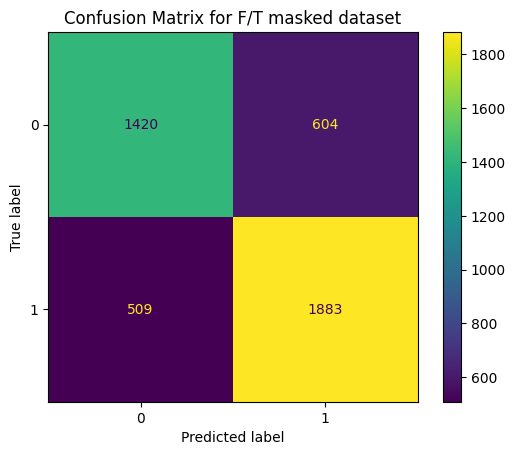

In [5]:
# Check that the models works correctly

# Create datasets
X_train, X_valid, y_train, y_valid = create_partition_from_split(df_train, df_valid, text_colname, trait)
_, X_test, _, y_test = create_partition_from_split(df_train, df_test, text_colname, trait)
train_dataset, valid_dataset = create_datasets(tokenizer, X_train, X_valid, y_train, y_valid)
_, test_dataset = create_datasets(tokenizer, X_train, X_test, y_train, y_test)

# Create trainer
trainer = Trainer(
        model=fine_tuned_model,          # the instantiated Transformers model to be trained
        args=None,                       # training arguments
        train_dataset=train_dataset,     # training dataset
        eval_dataset=test_dataset,      # evaluation dataset
        compute_metrics=compute_metrics, # the callback that computes metrics of interest
        #optimizers=(optimizer, None)
    )

results = trainer.evaluate()
conf_matrix = results['eval_conf_matrix']
print(results)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

# Add a title to the confusion matrix plot
plt.title("Confusion Matrix for F/T masked dataset")
plt.show()

In [9]:
import pickle

# Set the desired maximum sequence length
max_sequence_length = 450
attribution_threshold = 0.8 # Adjust the threshold as needed

# List to store word attributions for each row
all_word_attributions = []

# List to store sum of attributions for each row
all_sum_attributions = []

# Loop through all rows in the dataset
print("Number of rows:", len(df))
for row_index in range(len(df)):
    # Show progress every 100 sentences
    if row_index%100 == 0:
        print(row_index)
        
    preproc_text = get_preproc_text(df, row_index, tokenizer, 
                                    max_sequence_length, text_colname=text_colname)
    word_attributions = cls_explainer(preproc_text)
    true_class = df.loc[row_index, trait]
    predicted_class = cls_explainer.predicted_class_name

    # Print the terms with scores greater than the threshold
    for token, score in word_attributions:
        if abs(score) > attribution_threshold:
            print(f'Token: {token}, Score: {score}')

    # Save the filtered attributions for this row along with true_class and predicted_class
    attribution_info = (word_attributions, true_class, predicted_class)
    all_word_attributions.append(attribution_info)

    # Visualize if there are filtered attributions
    if any(abs(score) > attribution_threshold for _, score in word_attributions):
        cls_explainer.visualize(true_class=true_class)
    
    # Sum of attributions for the entire text
    sum_attribution = cls_explainer.attributions.attributions_sum.sum()

    # Save the sum of attributions for this row
    all_sum_attributions.append((sum_attribution.item(), true_class, predicted_class))
    
# Save all_word_attributions to a file
word_attr_fname = get_all_word_attr_fname_masked_mbti(trait)
with open(word_attr_fname, 'wb') as file:
    pickle.dump(all_word_attributions, file)

# Save all_sum_attributions to a file
sum_attr_fname = get_all_sum_attr_fname_masked_mbti(trait)
with open(sum_attr_fname, 'wb') as file:
    pickle.dump(all_sum_attributions, file)

Number of rows: 4416
0
Token: singer, Score: 0.8294975100226543


Token: values, Score: -0.8514480067236845


Token: values, Score: 0.8538849114129499


100
Token: had, Score: -0.8234404426387825


200
Token: robots, Score: 0.8522032668813572


Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors


300
Token: ideal, Score: 0.8525436220978245


400
Token: values, Score: 0.8477265424454182


Token: smarter, Score: 0.8008518971917404


Token: a, Score: 0.8117180202910956


500
Token: anxiety, Score: 0.8531490680350406


600
Token: humanitarian, Score: 0.8447012906979025


700
Token: sensitivity, Score: 0.8593386104505499


800
900
1000
Token: ideal, Score: 0.8215934180659598


Token: forrest, Score: -0.876860357584279


1100
Token: intellectual, Score: 0.9130422800204006


Token: beer, Score: 0.8676280913230313


1200
Token: people, Score: 0.8375265395188659


1300
Token: flowers, Score: -0.8156749062572946


1400
Token: science, Score: 0.8507724352064153


1500
Token: ##ock, Score: 0.8915450541822454


1600
Token: soul, Score: -0.8329101424164068


Token: writer, Score: -0.8292607914849955


Token: it, Score: 0.8098638942544447


Token: ideal, Score: 0.8053063559006819


1700
Token: work, Score: -0.9280897883356114


Token: ideal, Score: 0.8418857548182307


1800
1900
2000
Token: engineering, Score: 0.8663120025218466


2100
2200
Token: a, Score: -0.9057183895041738


2300
Token: ideal, Score: -0.8095214823888676


Token: ', Score: 0.8239032062972991


2400
Token: for, Score: -0.9411170961938955


2500
2600
2700
2800
Token: knowledge, Score: 0.802329377069113


2900
3000
3100
Token: spiritual, Score: -0.8286671326112749


3200
Token: harmony, Score: -0.8241687919185356


3300
3400
3500
3600
Token: logical, Score: 0.8345613380920004


Token: ideal, Score: 0.8864432431013075


3700
3800
Token: ideals, Score: 0.8840995761336973


3900
Token: for, Score: -0.8542597253225256


Token: ideal, Score: 0.8115264802232017


4000
Token: values, Score: 0.8329398394787053


4100
Token: gandhi, Score: 0.9389656937584995


4200
Token: values, Score: 0.875964524050445


Token: values, Score: 0.8081874835630894


4300
Token: anxiety, Score: 0.8360844619464621


4400
Token: king, Score: 0.815030356075837


In [5]:
import pickle

word_attr_fname = get_all_word_attr_fname_masked_mbti(trait)
sum_attr_fname = get_all_sum_attr_fname_masked_mbti(trait)

# Load the previously saved attributions from the file
with open(word_attr_fname, 'rb') as file:
    all_word_attributions = pickle.load(file)

# Load the previously saved attributions from the file
with open(sum_attr_fname, 'rb') as file:
    all_sum_attributions = pickle.load(file)

## Obtain Word Frequencies 

In [6]:
word_freq = get_word_freqs(all_word_attributions)
word_freq_label_1 = get_word_freqs(all_word_attributions, "LABEL_1")
word_freq_label_0 = get_word_freqs(all_word_attributions, "LABEL_0")

## Obtain Positive and Negative Attributions

In [7]:
# Get positive and negative attributions for the two labels
force_correct_classif=False
positive_attributions_label_1 = filter_attributions(all_word_attributions, '+', "LABEL_1", force_correct_classif)
positive_attributions_label_0 = filter_attributions(all_word_attributions, '+', "LABEL_0", force_correct_classif)
negative_attributions_label_1 = filter_attributions(all_word_attributions, '-', "LABEL_1", force_correct_classif)
negative_attributions_label_0 = filter_attributions(all_word_attributions, '-', "LABEL_0", force_correct_classif)

## Word Filtering Functions

In [8]:
#!pip install nltk

import nltk
from nltk.corpus import stopwords

# Obtain stop words
nltk.download('stopwords')
english_stopwords = stopwords.words('english')
#print(english_stopwords)

# Obtain list of words
nltk.download('words')
english_words = set(nltk.corpus.words.words())
#print(len(english_words))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Word Clouds
### By attribution score

In [9]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

min_word_freq = 10
min_word_len = 2
sum_techniques = ["freq", "avg", "max", "accum", "gmean"]
#sum_techniques = ["avg"]
#english_words=None
for sum_technique in sum_techniques:

    # Create separate lists for positive and negative attributions for LABEL_1
    filtered_words = filter_words(english_words, english_stopwords, word_freq_label_1, positive_attributions_label_1, min_word_freq, min_word_len, mbti_words)
    positive_words_label_1 = summarize_scores(filtered_words, sum_technique)
    filtered_words = filter_words(english_words, english_stopwords, word_freq_label_1, negative_attributions_label_1, min_word_freq, min_word_len, mbti_words)
    negative_words_label_1 = summarize_scores(filter_words(english_words, english_stopwords, word_freq, negative_attributions_label_1), sum_technique)

    # Create separate lists for positive and negative attributions for LABEL_0
    filtered_words = filter_words(english_words, english_stopwords, word_freq_label_0, positive_attributions_label_0, min_word_freq, min_word_len, mbti_words)
    positive_words_label_0 = summarize_scores(filtered_words, sum_technique)
    filtered_words = filter_words(english_words, english_stopwords, word_freq_label_0, negative_attributions_label_0, min_word_freq, min_word_len, mbti_words)
    negative_words_label_0 = summarize_scores(filtered_words, sum_technique)

    # Generate word clouds
    wordcloud_label_1_positive = WordCloud(background_color='white').generate_from_frequencies(positive_words_label_1)
    wordcloud_label_1_negative = WordCloud(background_color='white').generate_from_frequencies(negative_words_label_1)
    wordcloud_label_0_positive = WordCloud(background_color='white').generate_from_frequencies(positive_words_label_0)
    wordcloud_label_0_negative = WordCloud(background_color='white').generate_from_frequencies(negative_words_label_0)

    # Plot word clouds
    fig = plt.figure(figsize=(16, 8))

    plt.subplot(2, 2, 1)
    plt.imshow(wordcloud_label_1_positive, interpolation='bilinear')
    plt.title(trait + ": Word Cloud for Positive Attributions (LABEL_1) " + sum_technique)
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(wordcloud_label_1_negative, interpolation='bilinear')
    plt.title(trait + ": Word Cloud for Negative Attributions (LABEL_1) " + sum_technique)
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(wordcloud_label_0_positive, interpolation='bilinear')
    plt.title(trait + ": Word Cloud for Positive Attributions (LABEL_0) " + sum_technique)
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(wordcloud_label_0_negative, interpolation='bilinear')
    plt.title(trait + ": Word Cloud for Negative Attributions (LABEL_0) " + sum_technique)
    plt.axis('off')

    plt.tight_layout()
    
    # Save the figure as a high-resolution image
    filename = f"wordclouds_FT_{sum_technique}.png"
    plt.savefig(filename, dpi=300, bbox_inches = "tight")
    plt.close(fig)

## Barplots

In [9]:
min_word_freq = 10
min_word_len = 2
sum_technique = "avg"
# Create separate lists for positive and negative attributions for LABEL_1
filtered_words = filter_words(english_words, english_stopwords, word_freq_label_1, positive_attributions_label_1, min_word_freq, min_word_len, mbti_words)
positive_words_label_1 = summarize_scores(filtered_words, sum_technique)
filtered_words = filter_words(english_words, english_stopwords, word_freq_label_1, negative_attributions_label_1, min_word_freq, min_word_len, mbti_words)
negative_words_label_1 = summarize_scores(filter_words(english_words, english_stopwords, word_freq, negative_attributions_label_1), sum_technique)

# Create separate lists for positive and negative attributions for LABEL_0
filtered_words = filter_words(english_words, english_stopwords, word_freq_label_0, positive_attributions_label_0, min_word_freq, min_word_len, mbti_words)
positive_words_label_0 = summarize_scores(filtered_words, sum_technique)
filtered_words = filter_words(english_words, english_stopwords, word_freq_label_0, negative_attributions_label_0, min_word_freq, min_word_len, mbti_words)
negative_words_label_0 = summarize_scores(filtered_words, sum_technique)

# Plot horizontal bar plots for each category with both top and bottom significant words
plot_bar(positive_words_label_1, 'Positive Attributions (LABEL_1)', filename = "positive_label_1_barplot.png")
plot_bar(negative_words_label_1, 'Negative Attributions (LABEL_1)', filename = "negative_label_1_barplot.png")
plot_bar(positive_words_label_0, 'Positive Attributions (LABEL_0)', filename = "positive_label_0_barplot.png")
plot_bar(negative_words_label_0, 'Negative Attributions (LABEL_0)', filename = "negative_label_0_barplot.png")

Saved positive_label_1_barplot.png
Saved negative_label_1_barplot.png
Saved positive_label_0_barplot.png
Saved negative_label_0_barplot.png


## Histogram

In [ ]:
import matplotlib.pyplot as plt

# Create a histogram
filtered_sum_attributions = filter_sum_attributions(all_sum_attributions)
plt.hist(filtered_sum_attributions, bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Sum of Attributions Scores')
plt.xlabel('Sum of Attributions Scores')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create histograms
for pred_class in [None, "LABEL_1", "LABEL_0"]:
    sum_attributions = filter_sum_attributions(all_sum_attributions, pred_class=pred_class)
    hist, bins, _ = plt.hist(sum_attributions, bins=20, color='blue', alpha=0.7)
    plt.title('Histogram of Sum of Attributions Scores, pred_class=' + str(pred_class))
    plt.xlabel('Sum of Attributions Scores')
    plt.ylabel('Frequency')

    # Calculate the percentiles
    percentiles = np.percentile(sum_attributions, [25, 50, 75])

    # Print the percentile values
    for percentile_value in percentiles:
        print("Percentile value:", percentile_value)

    # Draw red lines at the percentile values
    for percentile_value in percentiles:
        plt.axvline(percentile_value, color='red', linestyle='--')

    plt.show()

## Texts: highest scores

In [ ]:
import numpy as np

# Set the desired maximum sequence length
max_sequence_length = 450

# Calculate the percentiles
# percentiles = np.percentile(all_total_attributions, [25, 75])

# Set the attribution threshold as the first and third percentile values
# attribution_threshold_lower = percentiles[0]
# attribution_threshold_upper = percentiles[1]

attribution_threshold_lower = -1.2264066739414712
attribution_threshold_upper = 3.9756553009835245

# Loop through all rows in the dataset
for row_index in range(len(df)):
    # Sum of attributions for the entire text
    sum_attribution = all_sum_attributions[row_index][0]

    # Check if the total attribution falls within the specified thresholds
    if abs(sum_attribution) < attribution_threshold_lower or abs(sum_attribution) > attribution_threshold_upper:
        # Extract row information
        preproc_text = get_preproc_text(df, row_index, tokenizer, 
                                        max_sequence_length, text_colname=text_colname)
        word_attributions = cls_explainer(preproc_text)
        true_class = df.loc[row_index, trait]
        predicted_class = cls_explainer.predicted_class_name
        
        # Save the filtered attributions for this row
        attribution_info = (sum_attribution, true_class, predicted_class)

        # Print the information only for rows meeting the threshold
        print(f'True Class for Row {row_index}: {true_class}')
        print(f'Total Attribution for Row {row_index}: {sum_attribution}')

        # Visualize if needed
        if abs(sum_attribution) < attribution_threshold_lower or abs(sum_attribution) > attribution_threshold_upper:
            cls_explainer.visualize(true_class=true_class)

## Visualize sorted lists (explainer)

In [ ]:
# Set the desired maximum sequence length
max_sequence_length = 450

# Obtain attributions
for pred_class in ["LABEL_1", "LABEL_0"]:

    sum_attributions = filter_sum_attributions(all_sum_attributions, pred_class=pred_class, get_attr_plus_idx=True)
    
    # Sort attributions
    sorted_list = sorted(sum_attributions, key=lambda x: x[0], reverse=True)

    # Visualize the attributions for the texts corresponding to the highest and lowest total attribution scores
    num_elements_to_show=10
    for element in sorted_list[:num_elements_to_show]:
        # Extract row information
        row_index = element[1]
        preproc_text = get_preproc_text(df, row_index, tokenizer, 
                                        max_sequence_length, text_colname=text_colname)
        word_attributions = cls_explainer(preproc_text)
        true_class = df.loc[row_index, trait]
        predicted_class = cls_explainer.predicted_class_name

        # Sum of attributions for the entire text
        sum_attribution = cls_explainer.attributions.attributions_sum.sum()

        print(all_sum_attributions[row_index], sum_attribution)

        # Visualize the attributions for the text
        cls_explainer.visualize(true_class=true_class)

## Trial

In [ ]:
# Define a function to get the HTML file name
def get_html_fname(pred_class):
    return 'attributions_' + pred_class + '.html'

# Set the desired maximum sequence length
max_sequence_length = 450

# Initialize the HTML content
html_content = "<html><head><title>Posts with highest scores</title></head><body>"

# Obtain attributions
for pred_class in ["LABEL_1", "LABEL_0"]:

    sum_attributions = filter_sum_attributions(all_sum_attributions, pred_class=pred_class, get_attr_plus_idx=True)
    
    # Sort attributions
    sorted_list = sorted(sum_attributions, key=lambda x: x[0], reverse=True)

    # Visualize the attributions for the texts corresponding to the highest and lowest total attribution scores
    num_elements_to_show=10
    for element in sorted_list[:num_elements_to_show]:
        # Extract row information
        row_index = element[1]
        preproc_text = get_preproc_text(df, row_index, tokenizer, 
                                        max_sequence_length, text_colname=text_colname)
        word_attributions = cls_explainer(preproc_text)
        true_class = df.loc[row_index, trait]
        predicted_class = cls_explainer.predicted_class_name

        # Sum of attributions for the entire text
        sum_attribution = cls_explainer.attributions.attributions_sum.sum()

        # Add the information to the HTML content
        html_content += f"<p>{all_sum_attributions[row_index]}, {sum_attribution}</p>"

        # Visualize the attributions for the text
        explanation_html = cls_explainer.visualize(true_class=true_class).data

        # Add the text to the HTML content
        html_content += str(explanation_html)

    # Close the HTML content
    html_content += "</body></html>"

    # Get the HTML file name
    html_fname = get_html_fname(pred_class)

    # Save the collected HTML content to a file
    with open(html_fname, 'w') as file:
        file.write(html_content)

    # Reset the HTML content for the next pred_class
    html_content = "<html><body>"

## Visualize sentences with a particular word (sum attribution ordering)

In [ ]:
def get_html_fname_mbti(word_of_interest):
    return 'avg_post_' + word_of_interest.replace("/", "_") + '.html'

# Set the desired maximum sequence length
max_sequence_length = 450

# Define the list of words of interest and other parameters
words_of_interest = ["king", "engineer", "spirit", "math", "bike"]
pred_class_of_interest = "LABEL_0"
max_elements_to_show = 10

for word_of_interest in words_of_interest:
    # Get filtered sum attributions
    sum_attributions = filter_sum_attributions(all_sum_attributions, pred_class=pred_class_of_interest, get_attr_plus_idx=True)
    
    # Sort attributions
    sorted_list = sorted(sum_attributions, key=lambda x: x[0], reverse=True)

    # Initialize HTML content string
    html_content = "<html><head><title>Word Attribution Scores</title></head><body>"

    num_elem = 0
    for element in sorted_list:
        # Extract row information
        row_index = element[1]
        
        word_attributions = all_word_attributions[row_index]
            
        # Check if word is contained in the current sentence
        score = get_max_word_score(word_of_interest, word_attributions)
        if score is not None:
            # Extract row information
            preproc_text = get_preproc_text(df, row_index, tokenizer, 
                                        max_sequence_length, text_colname=text_colname)
            word_attributions = cls_explainer(preproc_text)
            true_class = df.loc[row_index, trait]
            predicted_class = cls_explainer.predicted_class_name
            
            # Print score
            print(word_of_interest, "score:", score)

            # Visualize and collect HTML content
            explanation_html = cls_explainer.visualize(true_class=true_class).data
            html_content += f"<h3>{word_of_interest} score: {score}</h3>"
            html_content += str(explanation_html)  # Ensure conversion to string
            
            num_elem += 1
            if num_elem == max_elements_to_show:
                break

    # Close the HTML content
    html_content += "</body></html>"

    # Close the HTML file name
    html_fname = get_html_fname_mbti(word_of_interest)

    # Save the collected HTML content to a file
    with open(html_fname, 'w') as file:
        file.write(html_content)

## Visualize sentences with a particular word (word attribution ordering)

In [ ]:
def get_html_fname_mbti(word_of_interest):
    return 'avg_word_' + word_of_interest.replace("/", "_") + '.html'

# Set the desired maximum sequence length
max_sequence_length = 450

# Define the list of words of interest and other parameters
words_of_interest = ["king", "engineer", "spirit", "math", "bike"]
pred_class_of_interest = "LABEL_0"
max_elements_to_show = 10

for word_of_interest in words_of_interest:
    # Get word score info
    word_scores = get_max_word_scores(word_of_interest, all_word_attributions, pred_class_of_interest)

    # Sort word scores
    sorted_list = sorted(word_scores, key=lambda x: x[0], reverse=True)

    # Initialize HTML content string
    html_content = "<html><head><title>Word Attribution Scores</title></head><body>"

    for element in sorted_list[:max_elements_to_show]:
        # Extract row information
        row_index = element[1]
        
        word_attributions = all_word_attributions[row_index]
            
        # Check if word is contained in the current sentence
        score = get_max_word_score(word_of_interest, word_attributions)
        
        # Extract row information
        preproc_text = get_preproc_text(df, row_index, tokenizer, 
                                        max_sequence_length, text_colname=text_colname)
        word_attributions = cls_explainer(preproc_text)
        true_class = df.loc[row_index, trait]
        predicted_class = cls_explainer.predicted_class_name
            
        # Print score
        print(word_of_interest, "score:", score)

        # Visualize and collect HTML content
        explanation_html = cls_explainer.visualize(true_class=true_class).data
        html_content += f"<h3>{word_of_interest} score: {score}</h3>"
        html_content += explanation_html

    # Close HTML content string
    html_content += "</body></html>"

    # Get the HTML file name
    html_fname = get_html_fname_mbti(word_of_interest)

    # Save the collected HTML content to a file
    with open(html_fname, 'w') as file:
        file.write(html_content)